In [22]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")
 
if module_path not in sys.path:
    sys.path.append(module_path)

In [25]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
fig_dir = (Path().cwd().parents[0] / 'figures').absolute()

df_meta_path = data_dir /'tissue'  / 'metadata' / 'imgs_reg.csv'
df_imgs = pd.read_csv(df_meta_path)


In [26]:
df_imgs = df_imgs[df_imgs.FOV == '40X']

# Read PPI data

In [27]:
import pickle 

def read_PPI(path):
    with open(path, 'rb') as file:
        PPI_dict = pickle.load(file)

    return PPI_dict

In [28]:
PPI_save_path =  data_dir / 'tissue' / 'PPI'

dfs = []
for row in df_imgs.itertuples():
    name = '_'.join(row[1:3])

    # Read PPi

    PPI_dict = read_PPI(PPI_save_path / f'{name}.pkl')
    dfs_PPI_cyto = []
    dfs_PPI_nuclei = []
    for k in PPI_dict.keys():
        PPI_loc = PPI_dict[k][:, 1:3].astype(np.uint32)

        df = pd.DataFrame(PPI_loc, 
                      columns=['x', 'y'])
        df['PPI'] = k
        df['Condition'] = row[1]
        dfs.append(df)

# Concat dataframe
df = pd.concat(dfs)


In [29]:
df.to_csv(PPI_save_path / 'all.csv')

# Read H&E images

In [30]:
import networkx as nx 

# remove first and last consecutive zeros along dimension
def removeFirstAndLast(zeroArray):
    
    # remove first
    for ii, val in enumerate(zeroArray):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            lowest = ii # index of last of the first consecutive zeros
            
    # remove last
    for ii, val in enumerate(np.flip(zeroArray)):
        if np.sum(zeroArray[:ii + 1]) != ii + 1: # all consecutive trues
            break # exit loop
            
        else:
            highest = len(zeroArray) - ii # index of first of the last consecutive zeros            
    
    return (lowest, highest)

# remove black borders from napari screenshot (2D image)
def removeBorders(RGB):

    rowMin = []
    rowMax = []
    colMin = []
    colMax = []
    for jj in range(3): # each RGB
        
        img = RGB[:, :, jj]
        # find first and last rows and cols of all zeros
        # remove any rows of zeros
        zeroRows = np.all(img == 0, axis = 1)
        zeroCols = np.all(img == 0, axis = 0)

        posRows = removeFirstAndLast(zeroRows)
        posCols = removeFirstAndLast(zeroCols)            
        
        rowMin.append(posRows[0])
        rowMax.append(posRows[1])
        colMin.append(posCols[0])
        colMax.append(posCols[1])
        
    # make sure border signal is not cut out
    rowMin = np.min(rowMin)
    rowMax = np.max(rowMax)
    colMin = np.min(colMin)
    colMax = np.max(colMax)
        
    cropped = RGB[rowMin: rowMax, colMin: colMax, :] 
    
    return cropped

# Plot scatter
def plot_PPI_scatter(points, colors, img):
    # Napari viewer
    viewer = napari.view_image(img)
    for j, point in enumerate(points):
        points_layer = viewer.add_points(point, size=5, face_color=colors[j])

    # Get screenshot
    screenshot = viewer.screenshot(size=np.array((img.shape[1], img.shape[2]))*4)
    screenshot1 = removeBorders(screenshot)
    viewer.close()
    return screenshot1

[array(['Cyclin D1/CDK4', 'Cyclin E/CDK2', 'NF-Kb/p-P90rsk', 'Sox2/Oct4',
       'TRAIL/DR5'], dtype=object)]


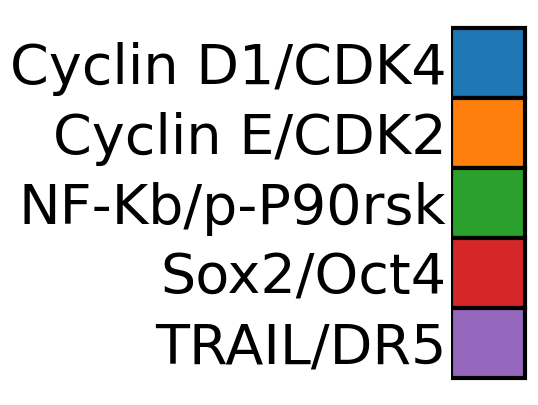

In [31]:
import palettable
from sklearn.preprocessing import OneHotEncoder

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()
print(enc.categories_)
PPIs_name = enc.categories_[0]

# Define colormap
colors  = palettable.tableau.Tableau_10.mpl_colors

colors_rgb = []
for color in colors:
    colors_rgb.append(np.array(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

# legend
fig, ax = plt.subplots(figsize=(1,len(PPIs_name)))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )

_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=40)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)

In [32]:
# df = pd.read_csv(PPI_save_path / 'all.csv')

In [33]:
df.PPI.value_counts()

Sox2/Oct4         26394
NF-Kb/p-P90rsk     8187
TRAIL/DR5          1821
Cyclin D1/CDK4     1723
Cyclin E/CDK2        93
Name: PPI, dtype: int64

In [13]:
from skimage import color

# Define dir
HE_dir = data_dir / 'tissue' / 'HE_registered'
# Define figure file 
fig_path = fig_dir / 'tisse' / 'FOV_HE'
fig_path.mkdir(parents=True, exist_ok=True)    

for row in df_imgs.itertuples():
    # Get info
    path = row.Path
    name = '_'.join(row[1:3])
    
    # Get HE path
    HE_path = HE_dir / f'{name}.tif'
    HE_img = tiff.imread(HE_path)

    # Transform grayscale
    img = color.rgb2gray(HE_img)

    # Get PPI data
    df_PPI = df[(df.Condition == row[1])]
    
    # Transform data to networkx
    G = nx.Graph()
    G.add_nodes_from([i for i in range(len(df_PPI))])
    coordinates = df_PPI[['x', 'y']].values
    nx.set_node_attributes(G, dict(zip(G.nodes(), coordinates)), "pos")
    nx.set_node_attributes(G, dict(zip(G.nodes(), df.PPI)), "labels")

    # Get info
    labels = list(nx.get_node_attributes(G, 'labels').values())
    node_colors = [colors_rgb_dict[i]/255 for i in labels]
    pos = nx.get_node_attributes(G, 'pos')
    pos_T = {k: v[[1,0]] for k,v in pos.items()}

    # Plot and save image
    fig, ax = plt.subplots(figsize=(20,10))
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_facecolor('k')

    nx.draw(G, pos_T, node_color=node_colors, with_labels=False, ax=ax, node_size=2, linewidths=0.1, edgecolors='k')

    fig.savefig(fig_path / f'{name}_gray.png', dpi=600, transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close()

# Show HE and IF images

In [55]:
def get_loc_ppi(df, Condition, x_min, y_min, x_max, y_max, PPI_name, merge=False, r=5):
    df_ppi = df[(df.Condition == Condition)]
    df_ppi = df_ppi[df_ppi.PPI == PPI_name]
    df_ppi = df_ppi[(df_ppi.column > x_min) & (df_ppi.column < x_max) 
                    & (df_ppi.row > y_min) & (df_ppi.row < y_max)] 
    if merge:
         # Get dot neighboring graph with user defined radius
        nei, A = get_NN_radius(df_ppi[['row', 'column']], r=r)

        # Assign new labels based on connected components label
        labels = scipy.sparse.csgraph.connected_components(A, directed=False)[1]
        df_ppi['CC_label'] = labels

        # Group by CC and extract mean position
        df_ppi = df_ppi.groupby(['CC_label'])[['row', 'column']].mean().astype(np.uint32)
        
    points = df_ppi[['row', 'column']].to_numpy()
    points = points - np.array([y_min, x_min])
    return points

In [47]:
from skimage import color 

# Define HE dir
HE_dir = data_dir / 'tissue' / 'HE_registered'

# Define cell mask dir
mask_dir =  data_dir / 'tissue' / 'masks'

for row in df_imgs.itertuples():
    # Get info
    path = row.Path
    name = '_'.join(row[1:3])
    
    # Get HE path
    HE_path = HE_dir / f'{name}.tif'
    HE_img = tiff.imread(HE_path)
    
    # Transform grayscale
    HE_img_gray = color.rgb2gray(HE_img)

    # Get IF images 
    with h5py.File(path, 'r') as f:
        markers = f['imgs'].attrs['Marker']
        imgs = f['imgs'][:]

    # Read cell mask
    mask_path = mask_dir / f'{row[1]}_cell.png'
    mask = skimage.io.imread(mask_path)
    break

In [70]:
from skimage import exposure

def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (50, 99.9))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    
    return img_rescale

IF_markers = ['CD8','Pan-cytokeratin','CD4']
imgs_subset = []
for i, m in enumerate(markers):
    if m in IF_markers:
        img = contrast_stretching(imgs[i])
        imgs_subset.append(img)

        

In [74]:
viewer = napari.view_image(np.stack(imgs_subset), name=IF_markers, channel_axis=0, contrast_limits=[0, 2**16])


In [72]:
viewer = napari.view_image(imgs, name=markers, channel_axis=0, visible=False)
viewer.add_image(HE_img)
viewer.add_labels(mask)

<Labels layer 'mask' at 0x1b1845bbac0>

In [45]:
import vispy.color

# Get small region 
x_min, x_max = 2600, 6400 
y_min, y_max = 1200, 3600

viewer = napari.view_image(imgs[:, y_min:y_max, x_min:x_max], name=markers, channel_axis=0, visible=False)
viewer.add_image(HE_img[y_min:y_max, x_min:x_max, :])
viewer.add_labels(mask[y_min:y_max, x_min:x_max])


<Labels layer 'Labels' at 0x1af7b746a30>

In [61]:

# Get small region 
x_min, x_max = 2600, 6400 
y_min, y_max = 1200, 3600

df.columns=['row', 'column', 'PPI', 'Condition', 'Labels']

# Get PPI 
PPIs = df.PPI.unique()
points = [get_loc_ppi(df, row.Condition, x_min, y_min, x_max, y_max, PPI_name) 
          for PPI_name in PPIs]
viewer = napari.view_image(HE_img_gray[y_min:y_max, x_min:x_max])

for i, point in enumerate(points):
    red = vispy.color.Colormap([[0.0, 0.0, 0.0], colors_rgb_dict[PPIs[i]]/255])
    points_layer = viewer.add_points(point, size=20)
    points_layer.face_color = colors_rgb_dict[PPIs[i]]/255